As with all techniques, ZNE is compatible with any frontend supported by Mitiq:



# Zero Noise Extrapolation(ZNE)

In [3]:
import mitiq
mitiq.SUPPORTED_PROGRAM_TYPES.keys()

['braket', 'cirq', 'pennylane', 'pyquil', 'qibo', 'qiskit']

Select front end 

In [2]:
frontend = "qiskit"

Importing Qiskit packages

In [4]:
import qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import Sampler, Estimator, Session, QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider
import pdb

# IBMProvider.save_account(token='bd93da0511f5a9af4510ba43068307e9bed56d16c9e90cb216c5973a5f8b423f5eeeff26d0d899f5210e1240e33a7080b718d1c4677c4e6f659895bfe0331fde', overwrite=True)
provider = QiskitRuntimeService()


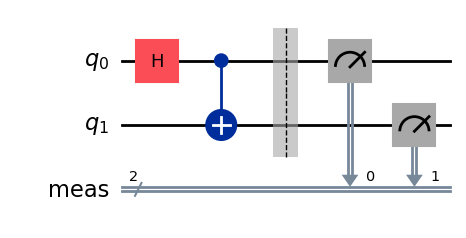

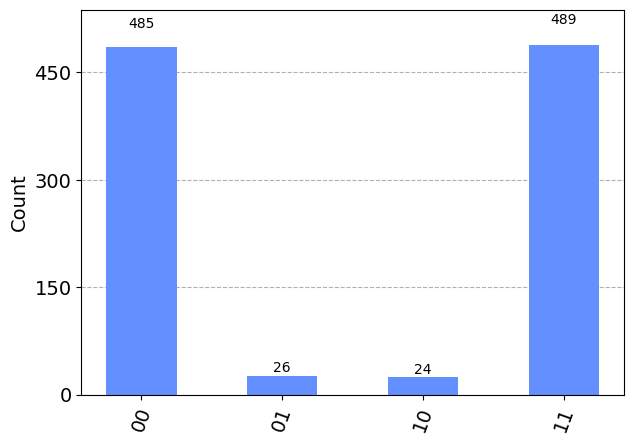

{'01': 26, '10': 24, '11': 489, '00': 485}

0.90234375


In [5]:
# check energy from sample
# def get_expectation(counts, num_shots):
#     expectation = ((counts["0"] if "0" in counts.keys() else 0) - (counts["1"] if "1" in counts.keys() else 0))/num_shots
#     return expectation        


def get_expectation(counts, num_shots, n_qubits):
    total_shots = sum(counts.values())
    total_z_expectation = 0
    for bitstring, count in counts.items():
        probability = count / total_shots
        z_expectation = 1  # Start with product of +1 for the whole system
        
        # Loop through each qubit in the bitstring
        for i in range(len(bitstring)):
            if bitstring[i] == '0':
                z_expectation *= 1  # |0⟩ -> +1
            else:
                z_expectation *= -1  # |1⟩ -> -1

        # Add the contribution to the total expectation value
        total_z_expectation += probability * z_expectation
    return total_z_expectation    



num_qubits = 2
qc = QuantumCircuit(num_qubits)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

display(qc.draw('mpl'))

machine_name = 'ibm_cleveland'
backend_name = provider.get_backend(machine_name)
backend = AerSimulator(method='statevector').from_backend(backend_name)       
qc = transpile(qc, backend)
num_shots = 1024
job = backend.run(circuits=qc, shots = num_shots)
counts = job.result().get_counts()
display(plot_histogram(counts)) 
display(counts)  

circuit_expectation = get_expectation(counts, num_shots, num_qubits)
print(circuit_expectation)

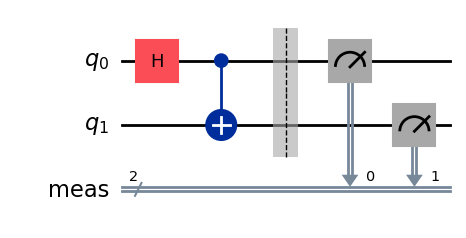

/Users/priyabratasenapati/opt/miniconda3/envs/error_mitigate/lib/python3.12/site-packages/mitiq/zne/inference.py:97: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(


Ideal Expectation : 1.0
Unmitigated : 0.908203125
Mitigated : 0.8789062499999986


In [6]:
from mitiq import zne
# from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise




num_qubits = 2
qc = QuantumCircuit(num_qubits)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
display(qc.draw('mpl'))


def ibmq_circuit_executor(qc: qiskit.QuantumCircuit, num_shots: int=1024)->float:
    # backend_name = provider.get_backend(machine_name)
    backend = AerSimulator(method='statevector')      
    qc = transpile(qc, backend)
    job = backend.run(circuits=qc, shots = num_shots)
    counts = job.result().get_counts() 

    total_shots = sum(counts.values())
    total_z_expectation = 0
    for bitstring, count in counts.items():
        probability = count / total_shots
        z_expectation = 1  # Start with product of +1 for the whole system
        
        # Loop through each qubit in the bitstring
        for i in range(len(bitstring)):
            if bitstring[i] == '0':
                z_expectation *= 1  # |0⟩ -> +1
            else:
                z_expectation *= -1  # |1⟩ -> -1

        # Add the contribution to the total expectation value
        total_z_expectation += probability * z_expectation
    return total_z_expectation




def ibmq_circuit_executor_noisy(qc: qiskit.QuantumCircuit, machine_name: str='ibm_cleveland', num_shots: int=1024)->float:
    backend_name = provider.get_backend(machine_name)
    backend = AerSimulator(method='statevector').from_backend(backend_name)       
    qc = transpile(qc, backend)
    job = backend.run(circuits=qc, shots = num_shots)
    counts = job.result().get_counts() 

    total_shots = sum(counts.values())
    total_z_expectation = 0
    for bitstring, count in counts.items():
        probability = count / total_shots
        z_expectation = 1  # Start with product of +1 for the whole system
        
        # Loop through each qubit in the bitstring
        for i in range(len(bitstring)):
            if bitstring[i] == '0':
                z_expectation *= 1  # |0⟩ -> +1
            else:
                z_expectation *= -1  # |1⟩ -> -1

        # Add the contribution to the total expectation value
        total_z_expectation += probability * z_expectation
    return total_z_expectation



ideal_expectation = ibmq_circuit_executor(qc)
noisy_expectation = ibmq_circuit_executor_noisy(qc)
mitigated_expectation = zne.execute_with_zne(qc, ibmq_circuit_executor_noisy)
print("Ideal Expectation :", ideal_expectation)
print("Unmitigated :", noisy_expectation)
print("Mitigated :", mitigated_expectation)


 
     

In [7]:
zne_value = zne.execute_with_zne(qc, ibmq_circuit_executor_noisy)

unmitigated_error = abs(ideal_expectation - noisy_expectation)
zne_error = abs(ideal_expectation - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")

/Users/priyabratasenapati/opt/miniconda3/envs/error_mitigate/lib/python3.12/site-packages/mitiq/zne/inference.py:97: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(


Estimation error without Mitiq   : 0.091796875
Estimation error with Mitiq (ZNE): 0.07812500000000078


In [8]:
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

ZNE reduced the estimation error by 14.9%.


### Select a noise scaling method

In [9]:
# Choise a unitary folding function
noise_scaling_function = zne.scaling.fold_global



Let's check the effect of the noise scaling function on the input circuit:

In [33]:
noise_scaled_circuit = noise_scaling_function(qc, scale_factor=8)

print(f"The input circuit has {len(qc)} gates")
print(f"The scaled circuit has {len(noise_scaled_circuit)} gates")

The input circuit has 5 gates
The scaled circuit has 18 gates


# Select an extrapolation method

In [34]:
# factory = zne.inference.AdaExpFactory(steps=10, asymptote=0.25)

# Examples:

# Richardson extrapolation
# factory = zne.inference.RichardsonFactory(scale_factors = [1, 2, 3])

# Exponential extrapolation
# factory = zne.inference.ExpFactory(scale_factors = [1, 2, 3], asymptote=0.25)

# Exponential adaptive extrapolation
factory = zne.inference.AdaExpFactory(steps=10, asymptote=0.25)

### Apply ZNE with non-default options

In [35]:
zne_value = zne.execute_with_zne(qc, ibmq_circuit_executor_noisy, scale_noise=noise_scaling_function, factory=factory)

unmitigated_error = abs(ideal_expectation - noisy_expectation)
zne_error = abs(ideal_expectation - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")

/Users/priyabratasenapati/opt/miniconda3/envs/error_mitigate/lib/python3.12/site-packages/mitiq/zne/inference.py:97: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(


Estimation error without Mitiq   : 0.091796875
Estimation error with Mitiq (ZNE): 0.08437793845849373


In [36]:
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

ZNE reduced the estimation error by 8.1%.


### Analize and visualize ZNE data 

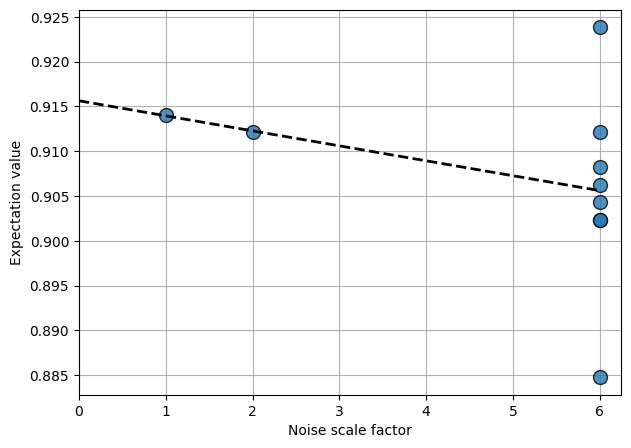

In [37]:
_ = factory.plot_fit()

In [38]:
factory.get_expectation_values()

[0.9140625,
 0.912109375,
 0.912109375,
 0.904296875,
 0.90234375,
 0.90234375,
 0.908203125,
 0.923828125,
 0.90625,
 0.884765625]

In [39]:
factory.get_scale_factors()

[1.0, 2.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]